In [4]:
import numpy as np
import pathlib
import time
import h5py
import obspy
import types
import pyasdf
import pickle
import math
import rasterio
from rasterio.plot import show
from rasterio.warp import calculate_default_transform, reproject, Resampling
from datetime import datetime
from datetime import timedelta
from scipy.signal import butter
from scipy.signal import filtfilt
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
from detection.stalta_detector import stalta_detector
from detection.master_event_correlation import correlate_master
from detection.master_event_correlation import threshold_detections
from detection.master_event_correlation import plot_catalog
from detection.template_match import make_templates
from detection.template_match import template_match
from detection.template_match import detection_timeseries
from clustering.clustering import get_input_waveforms
from clustering.clustering import load_waveform
from clustering.clustering import cluster_events
from clustering.clustering import plot_clusters
from location.compute_backazimuths_dev import compute_backazimuths
from location.compute_backazimuths_dev import get_detection_times
from location.compute_backazimuths_dev import get_station_coordinates
from location.compute_backazimuths_dev import get_station_grid_locations
from figures.figures import plot_backazimuths_on_imagery
from figures.figures import plot_events_and_gps
from figures.figures import get_stacks
from gps.gps import gps_ice_velocity
import pyproj
from pyproj import Proj,transform,Geod

In [5]:
'''

Download data and remove instrumental response

'''

# specify path to save data- folders will be created in this directory
data_path = "/media/Data/Data/PIG/MSEED/"
xml_path = "/media/Data/Data/PIG/XML/HH/"

# pull the data from IRIS servers

# remove instrumental response

# update path to data so subsequent cells will use data with the instrumental response removed
data_path = data_path + "noIR/"

In [ ]:
# load the old catalog
catalog_file = h5py.File('/home/setholinger/Documents/Projects/PIG/detections/templateMatch/multiTemplate/run3/detection_times.h5','r')
detection_timestamps = list(catalog_file["times"])
catalog_file.close()
detection_times = []
for i in range(len(detection_timestamps)):
    detection_times.append(datetime.utcfromtimestamp(detection_timestamps[i]))

# load the old clustering results
cluster_file = h5py.File("/home/setholinger/Documents/Projects/PIG/detections/templateMatch/multiTemplate/run3/short_3D_clustering/modified_k_shape/2/2_cluster_predictions_0.05-1Hz.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
cluster_file.close()

In [ ]:
'''

Compute backazimuths for all events in the catalog

'''

# initialize location parameter object and set parameters for backazimuth computation
l = types.SimpleNamespace()

# load catalog and detection times
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')
l.detection_times = get_detection_times(ds)
#l.detection_times = np.array(detection_times)[predictions == 1][-25000:-24000]

# set backazimuth computation parameters
l.win_len = 10
l.slide = 5
l.trace_len = 500
l.num_steps = int((l.trace_len-l.win_len)/l.slide)+1
l.network = "XC"
l.stations = ["PIG2","PIG4","PIG5"]

# set the coordinate system in which we will do all grid-based calculations
l.crs = "EPSG:3245"

# set signal-to-noise ratio for throwing out stations in backazimuth computation
l.snr_threshold = 0

# set sta/lta ratio for throwing out individual windows in backazimuth computation
l.stalta_threshold = 1

# specify method for correcting pca components 
l.pca_correction = "new"
l.centroid = "fixed"

# specify parameters for cross correlation based determination of station of first arrival
l.max_shift = 1000
l.freq = [0.05,1]
l.fs = 100

# specify paths to data and metadata
l.data_path = data_path
l.xml_path = xml_path
l.filename = "outputs/locations/new_catalog_" + '_'.join(l.stations) + "_" + l.pca_correction + "_pca_" + l.centroid + "_centroid"
l.n_procs = 10

# run the backazimuth code
b = compute_backazimuths(l)

# save the output
baz_file = open(l.filename + ".pickle", "wb")
pickle.dump(b, baz_file)
baz_file.close()

In [ ]:
# load the results of polarization analysis
baz_file = open(l.filename+".pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()
all_backazimuths = b.backazimuths

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

backazimuths = all_backazimuths[predictions == 1]

In [ ]:
# get station locations and array centroids
l.station_lon_lat_coords = get_station_coordinates(l)
l.station_grid_coords = get_station_grid_locations(l)
array_centroid = np.mean(l.station_grid_coords,axis=0)

# open LANDSAT imagery file and plot as it is, in EPSG:3031
original_file = "data/imagery/test_epsg_3245.TIF"

sat_imagery = rasterio.open(original_file)
sat_data = sat_imagery.read(1)

# Construct figure and axis to plot on
fig,ax = plt.subplots(figsize=(20,20))

axes_coords = np.array([0, 0, 1, 1])

ax_image = fig.add_axes(axes_coords)

# get corners of imagery extent
p2 = Proj("EPSG:3245",preserve_units=False)
p1 = Proj(proj='latlong',preserve_units=False)

# plot imagery
bounds = sat_imagery.bounds
ax_image.imshow(sat_data,cmap='gray',extent=[bounds[0],bounds[2],bounds[1],bounds[3]])

# define, transform, and plot lat/lon grid
lat = [-74,-75]
lon = [-98,-100,-102,-104]
x_lab_pos=[]
y_lab_pos=[]
line = np.linspace(-110,-90,100)
for i in lat:
    line_x,line_y = transform(p1,p2,line,np.linspace(i,i,100))
    ax_image.plot(line_x,line_y,linestyle='--',linewidth=0.5,c='gray',alpha=1)
    y_lab_pos.append(line_y[np.argmin(np.abs(line_x-bounds[0]))])
line = np.linspace(-80,-70,100)
for i in lon:
    line_x,line_y = transform(p1,p2,np.linspace(i,i,100),line)
    ax_image.plot(line_x,line_y,linestyle='--',linewidth=0.5,c='gray',alpha=1)
    x_lab_pos.append(line_x[np.argmin(np.abs(line_y-bounds[1]))])
ax_image.set_xlim([bounds[0],bounds[2]])
ax_image.set_ylim([bounds[1],bounds[3]])

# set ticks and labels for lat/lon grid
ax_image.set_xticks(x_lab_pos)
ax_image.set_xticklabels(labels=[str(lon[0]) + '$^\circ$',str(lon[1]) + '$^\circ$',str(lon[2]) + '$^\circ$',str(lon[3]) + '$^\circ$'])
ax_image.set_xlabel("Longitude")
ax_image.set_yticks(y_lab_pos)
ax_image.set_yticklabels(labels=[str(lat[0]) + '$^\circ$',str(lat[1]) + '$^\circ$'])
ax_image.set_ylabel("Latitude")

# properly center the polar plot on the array centroid
l.station_lon_lat_coords = get_station_coordinates(l)
l.station_grid_coords = get_station_grid_locations(l)
array_centroid = np.mean(l.station_grid_coords,axis=0)
x_pos = (array_centroid[0]-sat_imagery.bounds[0])/(sat_imagery.bounds[2]-sat_imagery.bounds[0])
y_pos = (array_centroid[1]-sat_imagery.bounds[1])/(sat_imagery.bounds[3]-sat_imagery.bounds[1])
width = 0.3


ax_polar = fig.add_axes([x_pos-width/2,y_pos-width/2,width,width], projection = 'polar')
ax_polar.set_theta_zero_location('N')
ax_polar.set_theta_direction(-1)

n,bins = np.histogram(b.backazimuths[~np.isnan(b.backazimuths)]*np.pi/180,bins=np.linspace(0,2*np.pi,37))

# Compute width of each bin
widths = np.diff(bins)

# By default plot frequency proportional to area
# Area to assign each bin
area = n / b.backazimuths.size

# Calculate corresponding bin radius
radius = (area/np.pi) ** .5
#radius = n

# Plot data on ax
patches = ax_polar.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                 edgecolor='C0', fill=True, linewidth=1,alpha = .5)

# Remove ylabels for area plots (they are mostly obstructive)
ax_polar.set_yticks([])
ax_polar.axis('off')

# plot station locations
ax_stats = fig.add_axes(axes_coords)
ax_stats.scatter(l.station_grid_coords[:,0],l.station_grid_coords[:,1],marker="^",c='black')
ax_stats.set_xlim([bounds[0],bounds[2]])
ax_stats.set_ylim([bounds[1],bounds[3]])
ax_stats.axis('off')

plt.savefig(l.filename + '.png')

In [ ]:
'''

Make some plots of backazimuthal distribution

'''

# load the results of polarization analysis
baz_file = open(l.filename, "rb")
b = pickle.load(baz_file)
baz_file.close()

# make a basic histogram
plt.hist(b.backazimuths[~np.isnan(b.backazimuths)],bins=np.linspace(0,360,37))
plt.xlabel("Backazimuth")
plt.ylabel("Number of Events")
plt.title("All Event Backazimuths")
plt.show()

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

# plot backazimuthal distribution for each cluster
for cluster in range(len(centroids)):
    cluster_backazimuths = b.backazimuths[predictions == cluster]
    plt.hist(cluster_backazimuths[~np.isnan(cluster_backazimuths)],bins=np.linspace(0,360,37))
    plt.xlabel("Backazimuth")
    plt.ylabel("Number of Events")
    plt.title("Cluster " + str(cluster) + " Backazimuths")
    plt.show()


In [ ]:
'''

Make the backazimuth figure in Olinger et al, 2021

'''


# load the results of polarization analysis
baz_file = open("outputs/locations/entire_old_catalog_cluster_1_PIG2_PIG4_PIG5_old_pca.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()

# load clustering results
# cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
# predictions = np.array(list(cluster_file["cluster_index"]))
# centroids = list(cluster_file["centroids"])
# cluster_file.close()

# get backazimuths of only the events in the dispersive cluster (cluster 0)
backazimuths = b.backazimuths

# open LANDSAT imagery file
file = "data/imagery/LC08_L1GT_001113_20131012_20170429_01_T2_B4.TIF"
sat_imagery = rasterio.open(file)

# make the figure
plot_backazimuths_on_imagery(backazimuths,sat_imagery,xml_path)

In [18]:
# get backazimuths for the subarray (PIG2,PIG4,PIG5) and the entire array for a particular pca correction method
baz_file = open("outputs/locations/new_catalog_PIG1_PIG2_PIG3_PIG4_PIG5_new_pca_moving_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()
all_array_backazimuths = b.backazimuths
baz_file = open("outputs/locations/new_catalog_PIG2_PIG4_PIG5_new_pca_moving_centroid.pickle", "rb")
b = pickle.load(baz_file)
baz_file.close()
all_subarray_backazimuths = b.backazimuths

# load catalog and detection times
ds = pyasdf.ASDFDataSet("outputs/detections/template_matching_catalog.h5",mode='r')
detection_times = get_detection_times(ds)

# load clustering results
cluster_file = h5py.File("outputs/clustering/2_cluster_results.h5","r")
predictions = np.array(list(cluster_file["cluster_index"]))
centroids = list(cluster_file["centroids"])
cluster_file.close()

array_backazimuths = all_array_backazimuths[predictions == 0]
subarray_backazimuths = all_subarray_backazimuths[predictions == 0]

In [80]:
# find an event that has a rift tip backazimuth with PIG2,PIG4,PIG5 but a 180 flipped backazimuth when all stations are included
ind = 4290
print(array_backazimuths[ind])
print(subarray_backazimuths[ind])

# get the time for this event
detection_time = detection_times[predictions==0][ind]
print(detection_time)

16.3969959245
351.448967374
2013-05-02 09:45:28.100000


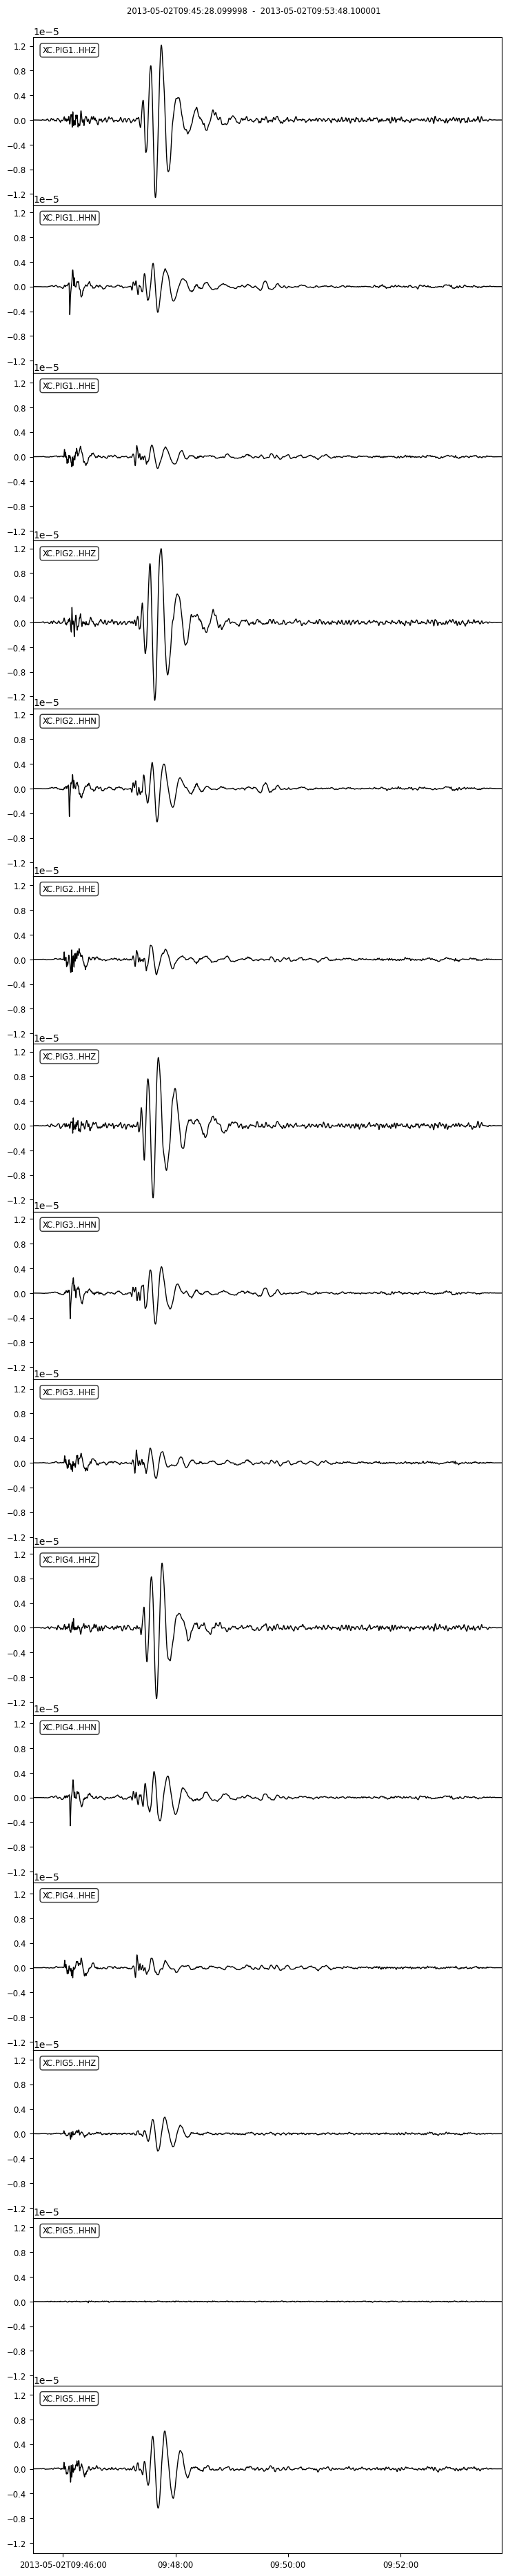

In [82]:
# plot it to make sure it has a decent SNR so the exploration of arrival time estimation is meaningful
#fname = "/media/Data/Data/PIG/MSEED/noIR/PIG*/HH*/2013-06-27.PIG*.HH*.noIR.MSEED"
fname = "/media/Data/Data/PIG/MSEED/noIR/PIG*/HH*/2013-05-02.PIG*.HH*.noIR.MSEED"
st = obspy.read(fname)
st.filter("bandpass",freqmin=0.05,freqmax=1.0)
detection_utc_time = obspy.UTCDateTime(detection_time)
st_event = st.copy()
st_event.trim(starttime=detection_utc_time,endtime=detection_utc_time+500)
st_event.taper(max_percentage=0.1, max_length=30.)
st_event.plot();

In [40]:
from obspy.signal.cross_correlation import correlate
from obspy.signal.cross_correlation import xcorr_max
from collections import Counter

def first_observed_arrival(st):
    # cross correlate all traces and find station with largest shift
    channels = ["HHZ","HHN","HHE"]
    first_stat_vector = []
    for chan in channels:
        st_chan = st.select(channel=chan)
        #st_chan.plot()
        shifts = np.zeros(len(st_chan))
        corrs = np.zeros(len(st_chan))
        for j in range(len(st_chan)):
            corr = correlate(st_chan[0], st_chan[j], 1000)
            shift, correlation_coefficient = xcorr_max(corr,abs_max=True)
            shifts[j] = shift
            corrs[j] = correlation_coefficient
#        print(shifts)
        stat_idx = np.argmax(shifts)
#        print(stat_idx)
#        print(st_chan[stat_idx].stats.station)
        first_stat_vector.append(st_chan[stat_idx].stats.station)
    counts = Counter(first_stat_vector).most_common(2)
    if len(counts) > 1:
        if counts[0][1] == counts[1][1]:
            first_stat = []
        else:
            first_stat = counts[0][0]
    else:
        first_stat = counts[0][0]
#    print(first_stat_vector)
    return first_stat

In [83]:
# check the result of first arrival estimation for both the subset and whole array
# they probably will be reversed
array_first_arrival = first_observed_arrival(st_event)
print(array_first_arrival)

st_event_subarray = obspy.Stream()
for s in ["PIG2","PIG4","PIG5"]:
    st_event_subarray += st_event.select(station=s)
subarray_first_arrival = first_observed_arrival(st_event_subarray)
print(subarray_first_arrival)

PIG3
PIG2


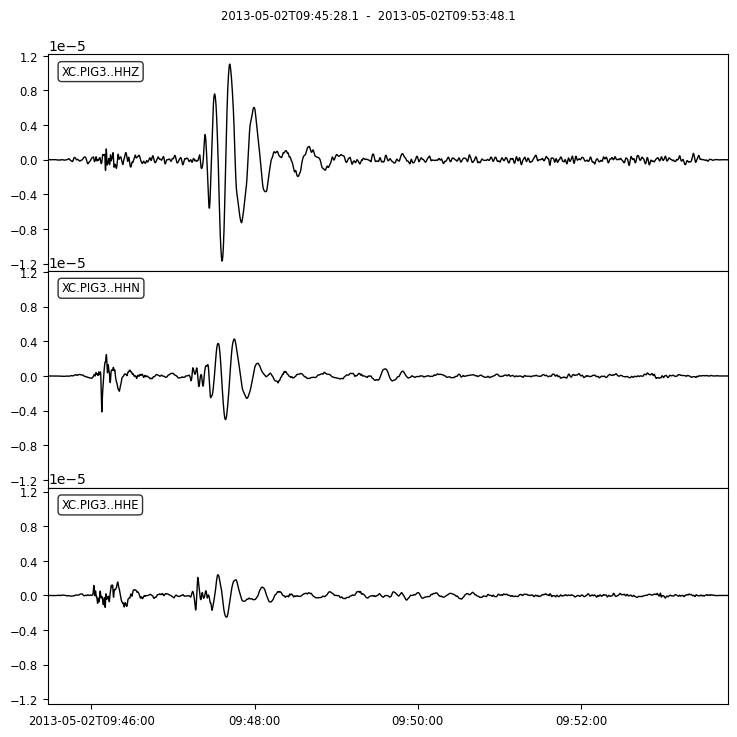

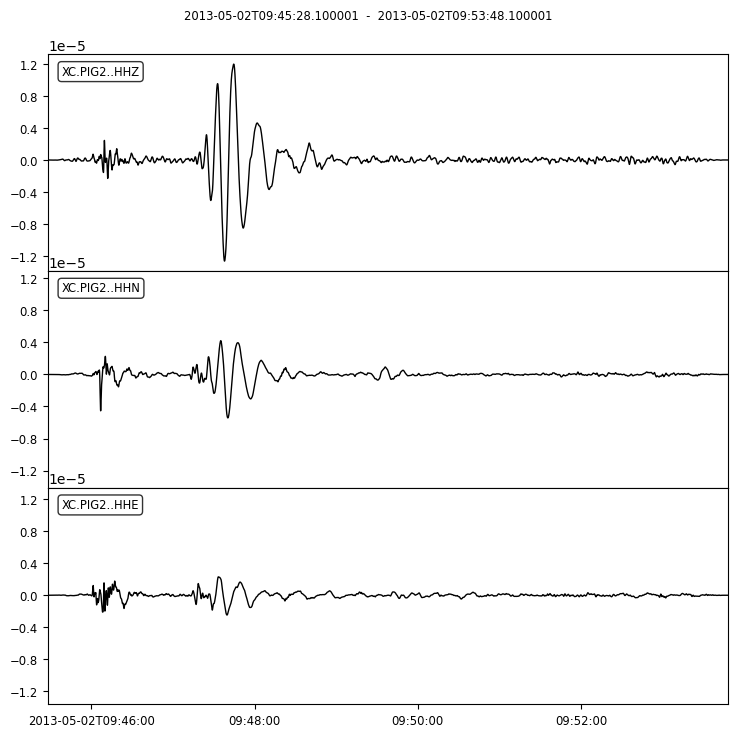

In [84]:
# plot just the traces from individual stations
st_event.select(station=array_first_arrival).plot();
st_event.select(station=subarray_first_arrival).plot();

In [86]:
# test first arrival between these two
st_test = st_event.select(station=array_first_arrival)
st_test += st_event.select(station=subarray_first_arrival)
test_first_arrival = first_observed_arrival(st_test)
print(test_first_arrival)

PIG3


In [93]:
# check number of quadrant 3 events for subarray vs whole array
print(len(subarray_backazimuths[np.logical_and(subarray_backazimuths > 180,subarray_backazimuths < 270)]))
print(len(array_backazimuths[np.logical_and(array_backazimuths > 180,array_backazimuths < 270)]))

1867
1763


In [94]:
# check number of quadrant 4 events for subarray vs whole array
print(len(subarray_backazimuths[np.logical_and(subarray_backazimuths > 270,subarray_backazimuths < 360)]))
print(len(array_backazimuths[np.logical_and(array_backazimuths > 270,array_backazimuths < 360)]))

4526
2417
